In [ ]:

import sys
import os

from sklearn.linear_model import SGDClassifier, LinearRegression, Lasso, Ridge
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
import seaborn as sn
import random
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict
from sklearn.manifold import TSNE
import tqdm
import copy
from sklearn.svm import LinearSVC 

from sklearn.cross_decomposition import PLSRegression
from sklearn.decomposition import TruncatedSVD
import torch
from sklearn.linear_model import SGDClassifier

from sklearn.svm import LinearSVC

import sklearn
from sklearn.linear_model import LogisticRegression
import random
import pickle
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn import neural_network
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import warnings
import argparse
from sklearn.neural_network import MLPClassifier
from collections import defaultdict
import scipy
from scipy import stats
from scipy.stats import pearsonr
import pandas as pd
from collections import Counter

In [ ]:
def load_bios(group):
    
    with open("bios_data/{}.pickle".format(group), "rb") as f:
        bios_data = pickle.load(f)
        z = np.array([1 if d["g"]=="f" else 0 for d in bios_data]) # gender labels
        professions = np.array([d["p"] for d in bios_data]) # profession labels
        txts = [d["hard_text_untokenized"] for d in bios_data] # biographies without gendered pronouns/names
        
    return z,txts,professions,bios_data

def load_bios_representations(group, finetune_mode, seed=0):
    
    if finetune_mode == "freezed": # only 1 random seed for the pretrained bert
        X = np.load("encodings//{}/{}_cls.npy".format(finetune_mode,group))
    else:
        X = np.load("encodings/{}/{}_{}_cls.npy".format(finetune_mode, group, seed))
    
    # perform PCA - as was done in training
    with open("pca/pca_{}_{}.pickle".format(finetune_mode, seed), "rb") as f:
        pca = pickle.load(f)
    X = pca.transform(X)
    
    # return transformed X
    return X

def load_projections(proj_type, finetune_mode, seed=0):
    with open("interim/{}/{}/run={}/Ps_{}.pickle".format(finetune_mode,proj_type,seed,proj_type), "rb") as f:
        rank2P = pickle.load(f)
        return rank2P

In [ ]:
z_train,txts_train,professions_train,train = load_bios("train")
z_test,txts_test,professions_test,test = load_bios("test")
z_dev,txts_dev,professions_dev,dev = load_bios("dev")


if False and os.path.exists("analysis/") and os.path.exists("analysis/mode2x.pickle") and os.path.exists("analysis/mode2p.pickle"):
    with open("analysis/mode2p.pickle", "rb") as f:
        mode2p = pickle.load(f)
    with open("analysis/mode2x.pickle", "rb") as f:
        mode2x = pickle.load(f)

else:
    if not os.path.exists("analysis"): os.mkdir("analysis")
    mode2x = defaultdict(dict)
    mode2p = defaultdict(dict)

    for mode in ["freezed", "linear-adv", "mlp-adv", "no-adv"]:
     
        for group in ["train", "dev", "test"]:
            mode2x[mode][group] = {}      
            num_seeds = 1 if mode == "freezed" else 5
        
            for seed in range(num_seeds):
                print(mode, group, seed)     
                X = load_bios_representations(group, mode, seed=seed)
                    
                mode2x[mode][group][seed] = X
                mode2p[mode][seed] = {} 
                for projtype in ["rlace", "inlp"]:
                    rank2P = load_projections(projtype, mode, seed=seed)
                    mode2p[mode][seed][projtype] = rank2P
                
            
    with open("analysis/mode2x.pickle", "wb") as f:
        pickle.dump(mode2x, f)
    with open("analysis/mode2p.pickle", "wb") as f:
        pickle.dump(mode2p, f)

In [ ]:
with open("analysis/mode2x.pickle", "rb") as f:
        mode2x = pickle.load(f)
with open("analysis/mode2p.pickle", "rb") as f:
        mode2p = pickle.load(f)

## finetune profession and gender classifiers

In [ ]:
def train_classifier(X,y,X_dev, y_dev, X_test,y_test):
    random.seed(0)
    np.random.seed(0)

#     clf = SGDClassifier(loss="log", fit_intercept=True,  max_iter=3, tol = 0.1*1e-3,n_iter_no_change=1,
#                            n_jobs=32,alpha=1e-4)
    clf = LogisticRegression(warm_start = True, penalty = 'l2',
                        solver = "saga", multi_class = 'multinomial', fit_intercept = True,
                        verbose = 5, n_jobs = 64, random_state = 1, max_iter = 10)
    
    clf.fit(X,y)
    score_dev = clf.score(X_dev,y_dev)
    score_test = clf.score(X_test, y_test)
    
    return clf, score_dev, score_test

random.seed(0)
np.random.seed(0)

prof_clfs = defaultdict(dict)
gender_clfs = defaultdict(dict)

for mode in ["freezed", "linear-adv", "mlp-adv", "no-adv"]:
    num_seeds = 1 if mode == "freezed" else 5
    for seed in range(num_seeds):
        prof_clfs[mode][seed] = dict()
        gender_clfs[mode][seed] = dict()
        print("============================")
        print("mode:", mode, "seed:", seed)
        for do_projection in [False, True]:
            
            
            
            X_train = mode2x[mode]["train"][seed]
            X_dev = mode2x[mode]["dev"][seed]
            X_test = mode2x[mode]["test"][seed]
            
            if not do_projection:
                prof_clf,prof_score_dev,prof_score_test = train_classifier(X_train, professions_train, X_dev, professions_dev, X_test, professions_test)
                prof_clfs[mode][seed][do_projection] = {"clf": prof_clf, "dev_score": prof_score_dev, "test_score": prof_score_test}
                
                gender_clf,gender_score_dev,gender_score_test = train_classifier(X_train, z_train, X_dev, z_dev, X_test, z_test)
                gender_clfs[mode][seed][do_projection] = {"clf": gender_clf, "dev_score": gender_score_dev, "test_score": gender_score_test}
                print("here", gender_score_dev, prof_score_dev)
            else:
                if mode in ["linear-adv", "mlp-adv"]: continue
                    
                prof_clfs[mode][seed][do_projection] = defaultdict(dict)
                gender_clfs[mode][seed][do_projection] = defaultdict(dict)
                
                for projtype in ["rlace", "inlp"]:
                    for rank in [1, 4, 8, 16, 32, 50, 64, 100]:
                        print(projtype, rank)
                        P = mode2p[mode][seed][projtype][0][rank if projtype == "rlace" else rank-1]
                        prof_clf,prof_score_dev,prof_score_test = train_classifier(X_train@P, professions_train, X_dev@P, professions_dev, X_test@P, professions_test)
                        prof_clfs[mode][seed][do_projection][projtype][rank] = {"clf": prof_clf, "dev_score": prof_score_dev, "test_score": prof_score_test} 
                        
                        gender_clf,gender_score_dev,gender_score_test = train_classifier(X_train@P, z_train, X_dev@P, z_dev, X_test@P, z_test)
                        gender_clfs[mode][seed][do_projection][projtype][rank] = {"clf": gender_clf, "dev_score": gender_score_dev, "test_score": gender_score_test}
                        print("here here", gender_score_dev, prof_score_dev)


In [ ]:
# with open("analysis/gender_clfs.pickle", "wb") as f:
#     pickle.dump(gender_clfs, f)
    
# with open("analysis/prof_clfs.pickle", "wb") as f:
#     pickle.dump(prof_clfs, f)

In [ ]:
with open("analysis/gender_clfs.pickle", "rb") as f:
    gender_clfs = pickle.load(f)
    
with open("analysis/prof_clfs.pickle", "rb") as f:
    prof_clfs = pickle.load(f)

## record clf accuracy vs rank

In [691]:
def create_df(clf_dict, mode, projtype, do_projection):
    d = defaultdict(dict) if do_projection else dict()
    num_seeds = 1 if mode == "freezed" else 5
    idx = list(range(num_seeds))
    ranks = [1, 4, 8, 16, 32, 50, 64, 100]
    
    for seed in range(num_seeds):
        if not do_projection:
            d[seed] = clf_dict[mode][seed][do_projection]["test_score"]
        else: 
            
            for rank in ranks:
                d[seed][rank] = clf_dict[mode][seed][do_projection][projtype][rank]["test_score"]
    
    try:
        df = pd.DataFrame(d)
    except:
        df = pd.DataFrame({k:[v] for k,v in d.items()}, index = range(len(ranks)))#, index = ranks)
    df['avg'] = df.mean(numeric_only=True, axis=1)
    df["std"] = df.std(numeric_only=True, axis=1)
    df.rename_axis("rank", inplace=True)
    df.reset_index(inplace=True)
    return df

def get_maj(Y):
    
    from collections import Counter
    c = Counter(Y)
    p,q = list(c.values())
    return max(p/(p+q), 1 - p/(p+q))

def plot(df_rlace, df_inlp, xlabel, ylabel, filename, baseline=None, baseline_label=None):

    sn.set()

    fig, ax = plt.subplots()
    plt.rcParams['font.family'] = 'Sans'

    df_rlace.plot('rank', 'avg', yerr='std', ax=ax, label="RLACE (ours)", marker="*")
    df_inlp.plot('rank', 'avg', yerr='std', ax=ax, label="INLP", marker="*")

    plt.ylabel(ylabel, fontsize=18)
    plt.xlabel(xlabel, fontsize=18)
    if baseline:
        ax.axhline(baseline, label=baseline_label, color = "black", linestyle="--")

    plt.legend(fontsize=18)
    #ax.yaxis.grid(color='gray', linestyle="-")
    #ax.xaxis.grid(color='gray', linestyle='-')
    plt.yticks(fontsize=18)
    #plt.xticks(range(1,21,2), fontsize=18)
    plt.subplots_adjust(bottom=0.17)
    plt.subplots_adjust(left=0.15)
    ax.figure.savefig("analysis/analysis-results/{}".format(filename), dpi = 700) 

    plt.show()

In [ ]:
mode2proj2profdf = defaultdict(dict)
mode2proj2genderdf = defaultdict(dict)

for mode in ["no-adv", "mlp-adv", "freezed", "linear-adv"]:
        for projtype in ["rlace", "inlp", "none"]:
            if (projtype != "none") and mode in ["mlp-adv", "linear-adv"]: continue
                
            df = create_df(prof_clfs, mode, projtype, True if projtype!="none" else False)
            mode2proj2profdf[mode][projtype] = df
            df = create_df(gender_clfs, mode, projtype, True if projtype!="none" else False)
            mode2proj2genderdf[mode][projtype] = df            
                

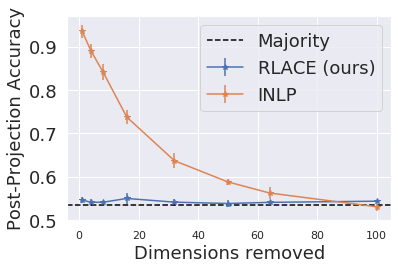

In [695]:
plot(mode2proj2genderdf["no-adv"]["rlace"], mode2proj2genderdf["no-adv"]["inlp"], "Dimensions removed", "Post-Projection Accuracy", "gender-finetuned.pdf", 
     get_maj(z_test),
    baseline_label="Majority")

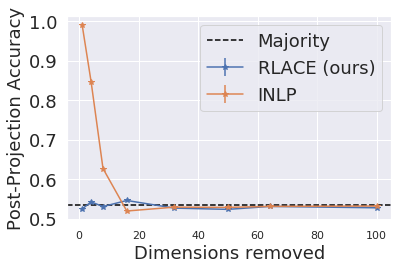

In [696]:
plot(mode2proj2genderdf["freezed"]["rlace"], mode2proj2genderdf["freezed"]["inlp"], "Dimensions removed", "Post-Projection Accuracy", "gender-freezed.pdf", 
     get_maj(z_test),
    baseline_label="Majority")

## TPR

In [ ]:
def get_TPR(y_pred, y_true, p2i, i2p, gender):
    
    scores = defaultdict(Counter)
    prof_count_total = defaultdict(Counter)
    i2g = {1: "f", 0: "m"}
    
    for y_hat, y, g in zip(y_pred, y_true, gender):
        if g == "m":
            g = 0
        if g == "f":
            g = 1
            
        if y == y_hat:
            
            scores[i2p[y]][i2g[g]] += 1
        
        prof_count_total[i2p[y]][i2g[g]] += 1
    
    tprs = defaultdict(dict)
    tprs_change = dict()
    tprs_ratio = []
    
    for profession, scores_dict in scores.items():
        if profession == "model": continue
            
        good_m, good_f = scores_dict["m"], scores_dict["f"]
        prof_total_f = prof_count_total[profession]["f"]
        prof_total_m = prof_count_total[profession]["m"]
        
        tpr_m = (good_m) / prof_total_m
        tpr_f = (good_f) / prof_total_f
        
        tprs[profession]["m"] = tpr_m
        tprs[profession]["f"] = tpr_f
        tprs_ratio.append(0)
        tprs_change[profession] = tpr_f - tpr_m
        
    return tprs, tprs_change, np.mean(np.abs(tprs_ratio))

def get_FPR2(y_pred, y_true, p2i, i2p, y_gender):
    
    fp = defaultdict(Counter)
    neg_count_total = defaultdict(Counter)
    pos_count_total = defaultdict(Counter)    


    label_set = set(y_true)
    # count false positive per gender & class
    
    for y_hat, y, g in zip(y_pred, y_true, y_gender):
        
        if y != y_hat:
            
            fp[y_hat][g] += 1 # count false positives for y_hat
    
    # count total falses per gender (conditioned on class)
    
    total_prof_g = defaultdict(Counter)
    
    # collect POSITIVES for each profession and gender
    
    for y,g in zip(y_true, y_gender):
        total_prof_g[y][g] += 1
    
    total_m = sum([total_prof_g[y]["m"] for y in label_set])
    total_f = sum([total_prof_g[y]["f"] for y in label_set])
    
    # calculate NEGATIVES for each profession and gender
    
    total_false_prof_g = defaultdict(Counter)    
    for y in label_set:
        total_false_prof_g[y]["m"] = total_m - total_prof_g[y]["m"]
        total_false_prof_g[y]["f"] = total_f - total_prof_g[y]["f"]
    
    fprs = defaultdict(dict)
    fprs_diff = dict()
    
    for profession, false_pred_dict in fp.items():

        false_male, false_female = false_pred_dict["m"],  false_pred_dict["f"]
        prof_total_false_for_male = total_false_prof_g[profession]["m"]
        prof_total_false_for_female = total_false_prof_g[profession]["f"]
        
        ftr_m = false_male/prof_total_false_for_male
        ftr_f = false_female/prof_total_false_for_female
        fprs[i2p[profession]]["m"] = ftr_m
        fprs[i2p[profession]]["f"] = ftr_f
        fprs_diff[i2p[profession]] = ftr_m - ftr_f
    
    return fprs, fprs_diff
        

    
def similarity_vs_tpr(tprs, word2vec, title, measure, prof2fem, plot=False):
    
    professions = list(tprs.keys())
    #
    """ 
    sims = dict()
    gender_direction = word2vec["he"] - word2vec["she"]
    
    for p in professions:
        sim = word2vec.cosine_similarities(word2vec[p], [gender_direction])[0]
        sims[p] = sim
    """
    tpr_lst = [tprs[p] for p in professions]
    sim_lst = [prof2fem[p] for p in professions]

    #professions = [p.replace("_", " ") for p in professions if p in word2vec]
    
    plt.plot(sim_lst, tpr_lst, marker = "o", linestyle = "none")
    plt.xlabel("% women", fontsize = 25)
    #plt.ylabel(r'$GAP_{female,y}^{TPR}$', fontsize = 20)
    plt.ylabel('TPR-Gap', fontsize = 25)
    for p in professions:
        x,y = prof2fem[p], tprs[p]
        plt.annotate(p , (x,y), size = 7, color = "red")
    plt.ylim(-0.4, 0.55)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    plt.subplots_adjust(bottom=0.21)
    plt.subplots_adjust(left=0.21)
    z = np.polyfit(sim_lst, tpr_lst, 1)
    p = np.poly1d(z)
    plt.plot(sim_lst,p(sim_lst),"r--")
    
    if plot:
        plt.savefig("analysis-results/{}_vs_bias_{}_bert.pdf".format(measure, title), dpi = 1000)
        print("Correlation: {}; p-value: {}".format(*pearsonr(sim_lst, tpr_lst)))
        plt.show()
        
    return pearsonr(sim_lst, tpr_lst)

def rms_diff(tpr_diff):

    return np.sqrt((1/(len(tpr_diff)-1)) * np.sum(tpr_diff**2))
    
def save_vecs_and_words(vecs, words):
    def to_string(arr):
        return "\t".join([str(x) for x in arr])
    
    with open("vecs.txt", "w") as f:
        for v in vecs:
            assert len(v) == 300
            f.write(to_string(v) + "\n")
    
    with open("labels.txt", "w") as f:
            f.write("Profession\n")
            for w in words:
                f.write(w + "\n")

def count_profs_and_gender(data):
    
    counter = defaultdict(Counter)
    for entry in data:
        gender, prof = entry["g"], entry["p"]
        counter[prof][gender] += 1
        
    return counter

def eval_tpr_rms(P, clf, X, y_gender,train,profs):

    prof2fem = {}
    counter = count_profs_and_gender(train)
    f,m=0.,0.
    for k, values in counter.items():
        f += values['f']
        m += values['m']
        prof2fem[k] = values['f']/(values['f'] + values['m'])
    i2p = {w:w for w in set(profs.tolist())}
    p2i = i2p

    y_pred_after = clf.predict((P.dot(X.T)).T)
    tprs, tprs_change, mean_ratio_after = get_TPR(y_pred_after, profs, p2i, i2p, y_gender)
    #similarity_vs_tpr(tprs_change_after, None, "after", "TPR", prof2fem) 
    
    change_vals = np.array(list((tprs_change.values())))

    return rms_diff(change_vals)

In [ ]:
mode2proj2seed2tpr = defaultdict(dict)
mode2proj2seed2corr = defaultdict(dict)
mode2proj2seed2profacc = defaultdict(dict)
mode2proj2seed2genderacc = defaultdict(dict)

for mode in ["freezed", "no-adv", "mlp-adv", "linear-adv"]:
    for projtype in ["rlace", "inlp", "none"]:
        if projtype!="none" and mode in ["mlp-adv", "linear-adv"]: continue
        mode2proj2seed2tpr[mode][projtype] = defaultdict(dict)
        mode2proj2seed2corr[mode][projtype] = defaultdict(dict)
        mode2proj2seed2profacc[mode][projtype] = defaultdict(dict)
        mode2proj2seed2genderacc[mode][projtype] = defaultdict(dict)
        
        num_seeds = 1 if mode == "freezed" else 5
        for seed in range(num_seeds):
            for rank in [1,50,100]:
                if projtype != "none":
                    clf = prof_clfs[mode][seed][True][projtype][rank]["clf"]
                    P =  mode2p[mode][seed][projtype][0][rank if projtype!="inlp" else rank-1]
                    gender_clf_acc = gender_clfs[mode][seed][True][projtype][rank]["test_score"]
                else:
                    clf = prof_clfs[mode][seed][False]["clf"]
                    gender_clf_acc = gender_clfs[mode][seed][False]["test_score"]
                    P = np.eye(300)
                
                tpr =  eval_tpr_rms(P, clf,  mode2x[mode]["test"][seed], z_test,test,professions_test)
                y_pred = clf.predict(mode2x[mode]["test"][seed]@P)
                i2p = {w:w for w in set(professions_dev.tolist())}
                p2i = i2p
                tprs, tprs_change, mean_ratio = get_TPR(y_pred, professions_test, p2i, i2p, z_test)
                corr = similarity_vs_tpr(tprs_change, None, "before", "TPR", prof2fem,plot=False)[0]

                mode2proj2seed2tpr[mode][projtype][seed][rank] = tpr
                 mode2proj2seed2corr[mode][projtype][seed][rank] = corr
                mode2proj2seed2profacc[mode][projtype][seed][rank] = (y_pred==professions_test).mean()
                mode2proj2seed2genderacc[mode][projtype][seed][rank] = gender_clf_acc

In [ ]:
 mode2p["freezed"].keys()

In [681]:
for mode in ["no-adv", "mlp-adv", "linear-adv", "freezed"]:
    for projtype in ["none", "rlace", "inlp"]:
        if projtype!="none" and mode in ["mlp-adv", "linear-adv"]: continue
        df = pd.DataFrame(mode2proj2seed2tpr[mode][projtype])
        df['avg'] = df.mean(numeric_only=True, axis=1)
        df["std"] = df.std(numeric_only=True, axis=1)
        df.rename_axis("rank", inplace=True)
        df.reset_index(inplace=True)
        print("Mode: {}; proj: {}; TPR-gap:".format(mode, projtype))
        print(df)
        print("---------------")
        df = pd.DataFrame(mode2proj2seed2corr[mode][projtype])
        df['avg'] = df.mean(numeric_only=True, axis=1)
        df["std"] = df.std(numeric_only=True, axis=1)
        df.rename_axis("corr", inplace=True)
        df.reset_index(inplace=True)
        print("Mode: {}; proj: {}; Corr:".format(mode, projtype))
        print(df)
        print("----------------")
             
        df =  pd.DataFrame(mode2proj2seed2profacc[mode][projtype])
        df['avg'] = df.mean(numeric_only=True, axis=1)
        df["std"] = df.std(numeric_only=True, axis=1)
        df.rename_axis("Acc.", inplace=True)
        df.reset_index(inplace=True)
        print("Mode: {}; proj: {}; Profession prediction accuracy:".format(mode, projtype))
        print(df) 
        print("----------------")
             
        df =  pd.DataFrame(mode2proj2seed2genderacc[mode][projtype])
        df['avg'] = df.mean(numeric_only=True, axis=1)
        df["std"] = df.std(numeric_only=True, axis=1)
        df.rename_axis("Acc.", inplace=True)
        df.reset_index(inplace=True)
        print("Mode: {}; proj: {}; Gender prediction accuracy:".format(mode, projtype))
        print(df)     
        print("=====================================")

Mode: no-adv; proj: none; TPR-gap:
   rank         0         1         2         3         4       avg       std
0     1  0.119659  0.103819  0.136586  0.121378  0.134014  0.123091  0.011726
1    50  0.119659  0.103819  0.136586  0.121378  0.134014  0.123091  0.011726
2   100  0.119659  0.103819  0.136586  0.121378  0.134014  0.123091  0.011726
---------------
Mode: no-adv; proj: none; Corr:
   corr        0         1         2         3         4       avg       std
0     1  0.82931  0.829949  0.816137  0.767587  0.810962  0.810789  0.022826
1    50  0.82931  0.829949  0.816137  0.767587  0.810962  0.810789  0.022826
2   100  0.82931  0.829949  0.816137  0.767587  0.810962  0.810789  0.022826
----------------
Mode: no-adv; proj: none; Profession prediction accuracy:
   Acc.         0         1         2         3         4       avg       std
0     1  0.850891  0.852335  0.849884  0.851877  0.851125  0.851222  0.000846
1    50  0.850891  0.852335  0.849884  0.851877  0.851125  0.85122

In [ ]:
x=5
print(x)

In [ ]:
seed=0
mode = "freezed"
projtype = "rlace"
rank=1

prof2fem = dict()
from collections import Counter
counter = count_profs_and_gender(train)
f,m=0.,0.
for k, values in counter.items():
    f += values['f']
    m += values['m']
    prof2fem[k] = values['f']/(values['f'] + values['m'])
    
clf_original = prof_clfs[mode][seed][False]["clf"] 
clf_finetuned = prof_clfs[mode][seed][True][projtype][rank]["clf"] if projtype!="none" else clf_original
P = mode2p[mode][seed][projtype][0][rank if projtype == "rlace" else rank-1] if projtype != "none" else np.eye(300)
tpr_before =  eval_tpr_rms(np.eye(300), clf_original,  mode2x[mode]["test"][seed], z_test,test, professions_test)
tpr_after = eval_tpr_rms(P, clf_finetuned,  mode2x[mode]["test"][seed], z_test,test, professions_test)

#clf = SGDClassifier()
#clf.fit(mode2x[mode]["train"][seed]@P, professions_train)
print("profession clf score finetuned on projected data", clf_finetuned.score(mode2x[mode]["dev"][seed]@P, professions_dev))
print("profession clf score original", clf_original.score(mode2x[mode]["dev"][seed], professions_dev))
print("profession clf score original on projected data", clf_original.score(mode2x[mode]["dev"][seed]@P, professions_dev))


y_pred = clf_original.predict(mode2x[mode]["dev"][seed]@P)
i2p = {w:w for w in set(professions_dev.tolist())}
p2i = i2p
tprs_after, tprs_change_after, mean_ratio_after = get_TPR(y_pred, professions_dev, p2i, i2p, z_dev)
corr_after = similarity_vs_tpr(tprs_change_after, None, "before", "TPR", prof2fem,plot=False)[0]


In [ ]:
df.rank==32

In [ ]:

y_pred = clf_original.predict(mode2x[mode]["dev"][seed])
i2p = {w:w for w in set(professions_dev.tolist())}
p2i = i2p
tprs_before, tprs_change_before, mean_ratio_before = get_TPR(y_pred, professions_dev, p2i, i2p, z_dev)
corr_before = similarity_vs_tpr(tprs_change_before, None, "before", "TPR", prof2fem,plot=False)[0]

In [ ]:
tpr_before, tpr_after

In [ ]:
corr_before, corr_after

In [ ]:
pca = PCA(n_components=2)
X_proj =pca.fit_transform(mode2x[mode]["test"][seed])
sn.scatterplot(X_proj[:,0], X_proj[:,1], hue = z_test)

In [ ]:
pca = PCA(n_components=2)
P  = mode2p[mode][seed][projtype][0][rank if projtype == "rlace" else rank-1]
X_proj =pca.fit_transform(mode2x[mode]["test"][seed]@P)
sn.scatterplot(X_proj[:,0], X_proj[:,1], hue = z_test)

In [ ]:
clf1 = SGDClassifier()
clf1.fit(mode2x[mode]["train"][seed], professions_train)

clf2 = SGDClassifier()
clf2.fit(mode2x[mode]["train"][seed]@P, professions_train)

In [ ]:
preds1 = clf1.predict(mode2x[mode]["dev"][seed])
preds2 = clf2.predict(mode2x[mode]["dev"][seed]@P)

In [ ]:
preds1

In [ ]:
preds2

In [ ]:
preds2.mean()